# Importing libraries


In [1]:
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import spatial
from sklearn.cluster import KMeans
plt.figure(figsize=(10, 10))
inputLoc = '../data/inputs/'
outputLoc = '../data/outs/'


<Figure size 720x720 with 0 Axes>

# Thresholding dartboard


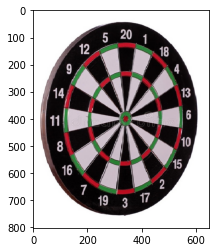

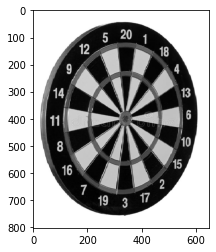

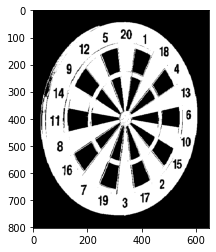

In [2]:
dart = cv2.imread(inputLoc + 'dartSide.jpg')
dart = cv2.cvtColor(dart, cv2.COLOR_BGR2RGB)
# show
plt.imshow(dart)
plt.show()
dartGray = cv2.cvtColor(dart, cv2.COLOR_RGB2GRAY)
plt.imshow(dartGray, cmap='gray')
plt.show()

# run otsu
ret, thresh = cv2.threshold(
    dartGray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')
plt.show()


# Red Bitmask


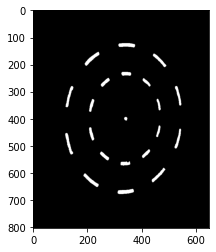

In [3]:
# find pixel mask consisting mainly of pixels that are more red
# plt.imshow(dart)
# plt.show()
thres = 15000
Rmask = np.zeros(dart.shape[:2], dtype=np.uint8)
dart = dart.astype(float)
for i in range(dart.shape[0]):
    for j in range(dart.shape[1]):
        # find distance of red from blue and green
        dist = abs(dart[i][j][0] - dart[i][j][1]) * \
            abs(dart[i][j][0] - dart[i][j][2])
        if dist > thres:
            Rmask[i][j] = 255
dart = dart.astype(np.uint8)
# run median filter
Rmask = cv2.medianBlur(Rmask, 5)

plt.imshow(Rmask, cmap='gray')
plt.savefig(outputLoc + 'Rmask.png')

plt.imshow(Rmask, cmap='gray')
plt.show()


# Green Bitmask


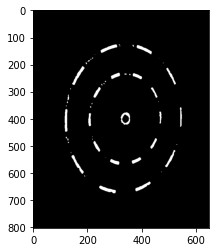

In [4]:
# green mask
thres = 4000
Gmask = np.zeros(dart.shape[:2], dtype=np.uint8)
dart = dart.astype(float)
for i in range(dart.shape[0]):
    for j in range(dart.shape[1]):
        # find distance of red from blue and green
        dist = abs(dart[i][j][1] - dart[i][j][0]) * \
            abs(dart[i][j][1] - dart[i][j][2])
        if dist > thres:
            Gmask[i][j] = 255
dart = dart.astype(np.uint8)

# run median filter
Gmask = cv2.medianBlur(Gmask, 5)

# plt.imshow(dart)
# plt.show()

plt.imshow(Gmask, cmap='gray')
plt.savefig(outputLoc + 'Gmask.png')

plt.imshow(Gmask, cmap='gray')
plt.show()


As you can see there are slight distortions. The reason for this is that most of the colors in a real photograph are not pure. We can only threshold however inaccuracies can still seep in. Though as we will see that this doe snot affect our program in anyway.


# Total Bitmask


[  0 255]


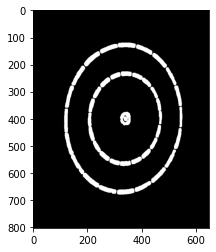

In [5]:
totalMask = Rmask.astype(float) + Gmask.astype(float)
totalMask = totalMask.astype(np.uint8)

# threshold
totalMask[totalMask > 127] = 255
totalMask[totalMask <= 127] = 0
print(np.unique(totalMask))
# dilate
kernel = np.ones((5, 5), np.uint8)
totalMask = cv2.dilate(totalMask, kernel, iterations=1)
plt.imshow(totalMask, cmap='gray')
plt.savefig(outputLoc + 'totalMask.png')

plt.imshow(totalMask, cmap='gray')
plt.show()

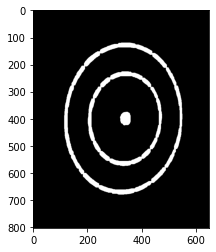

In [6]:
# run closing on mask
kernel = np.ones((33, 33), np.uint8)
totalMaskC = cv2.morphologyEx(totalMask, cv2.MORPH_CLOSE, kernel)
plt.imshow(totalMaskC, cmap='gray')
plt.show()


# Finding the zero point map and scoring region

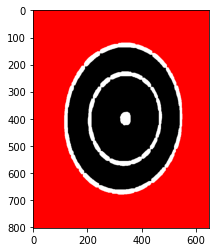

(803, 649, 3)


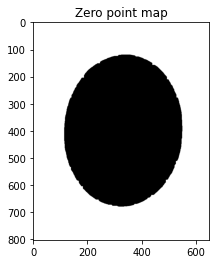

In [7]:
# flood fill white at 0, 0
h, w = totalMaskC.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
zeroPt = totalMaskC.copy()
zeroPt = np.dstack((zeroPt, zeroPt, zeroPt))
cv2.floodFill(zeroPt, mask, (0, 0), (255, 0, 0))
# show
plt.imshow(zeroPt, cmap='gray')
plt.show()

# convert to white if not red
zeroPt = zeroPt.astype(float)
print(zeroPt.shape)
for i in range(zeroPt.shape[0]):
    for j in range(zeroPt.shape[1]):
        if not np.array_equal(zeroPt[i][j], [255, 0, 0]):
            zeroPt[i][j] = (0, 0, 0)
        else:
            zeroPt[i][j] = (255, 255, 255)

zeroPt = zeroPt.astype(np.uint8)
# show
plt.title("Zero point map")
plt.imshow(zeroPt, cmap='gray')
plt.savefig(outputLoc + 'zeroPt.png')

plt.imshow(zeroPt, cmap='gray')
plt.show()


# Find single point map

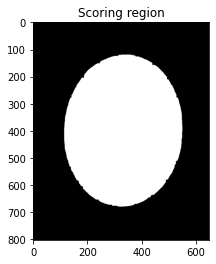

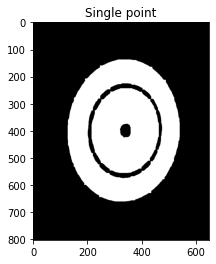

In [8]:
scoringRegion = 255 - zeroPt[:, :, 0]

# show
plt.title("Scoring region")
plt.imshow(scoringRegion, cmap='gray')
plt.show()

singlePoint = scoringRegion - totalMaskC
# show
plt.title("Single point")
plt.imshow(singlePoint, cmap='gray')
plt.savefig(outputLoc + 'singlePoint.png')

plt.imshow(singlePoint, cmap='gray')
plt.show()


# Find double point ring

[  0 255]


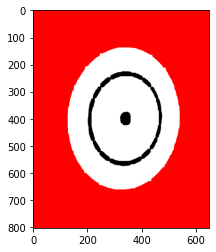

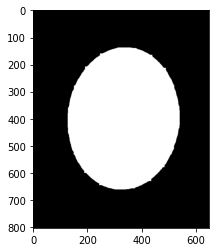

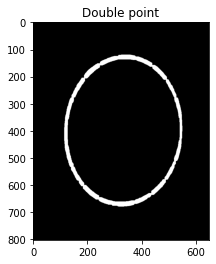

In [9]:
floodedSingle = singlePoint.copy()
floodedSingle = np.dstack((floodedSingle, floodedSingle, floodedSingle))
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(floodedSingle, mask, (0, 0), 255)
print(np.unique(floodedSingle))
plt.imshow(floodedSingle)
plt.show()


# black out all non red
floodedSingle = floodedSingle.astype(float)
for i in range(floodedSingle.shape[0]):
    for j in range(floodedSingle.shape[1]):
        if not np.array_equal(floodedSingle[i][j], [255, 0, 0]):
            floodedSingle[i][j] = (255, 255, 255)
        else:
            floodedSingle[i][j] = (0, 0, 0)

floodedSingle = floodedSingle.astype(np.uint8)


plt.imshow(floodedSingle)
plt.show()

doublePt = scoringRegion - floodedSingle[:, :, 0]
# dilate double pt


# show
plt.title("Double point")
plt.imshow(doublePt, cmap='gray')
plt.savefig(outputLoc + 'doublePt.png')

plt.imshow(doublePt, cmap='gray')
plt.show()


# Find inner bullseye

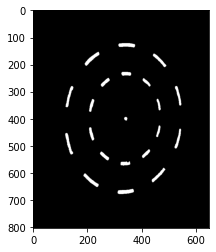

(803, 649)
[336 400]
327 401


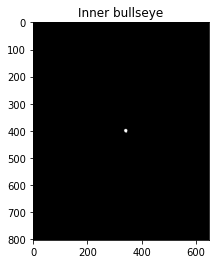

In [10]:
# show red bitmask
plt.imshow(Rmask, cmap='gray')
plt.show()

# find avg of all white points (center)
xAvg = 0
yAvg = 0
print(Rmask.shape)
for i in range(Rmask.shape[0]):
    for j in range(Rmask.shape[1]):
        if Rmask[i][j] == 255:
            xAvg += j
            yAvg += i


xAvg = xAvg / np.count_nonzero(Rmask)
yAvg = yAvg / np.count_nonzero(Rmask)

xAvg = int(xAvg)
yAvg = int(yAvg)


test = Rmask.copy()
test = np.dstack((test, test, test))

target = (int(xAvg), int(yAvg))
nonzero = cv2.findNonZero(Rmask)
distances = np.sqrt((nonzero[:, :, 0] - target[0])
                    ** 2 + (nonzero[:, :, 1] - target[1])**2)
nearestIdx = np.argmin(distances)

nearestWhite = nonzero[nearestIdx][0]

print(nearestWhite)

# flood fill at nearestWhite
# mask = np.zeros((h+2, w+2), np.uint8)
# cv2.floodFill(test, mask, (nearestWhite[0], nearestWhite[1]), 255)


# # show
# plt.title("Center of red")
# plt.imshow(test)
# plt.show()

print(xAvg, yAvg)

innerBullseye = np.dstack((Rmask, Rmask, Rmask))

# flood fill at avg
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(innerBullseye, mask, (nearestWhite[0], nearestWhite[1]), 255)

# black out all non red
innerBullseye = innerBullseye.astype(float)
for i in range(innerBullseye.shape[0]):
    for j in range(innerBullseye.shape[1]):
        if np.array_equal(innerBullseye[i][j], [255, 0, 0]):
            innerBullseye[i][j] = (255, 255, 255)
        else:
            innerBullseye[i][j] = (0, 0, 0)

innerBullseye = innerBullseye.astype(np.uint8)[:, :, 0]

plt.title("Inner bullseye")
plt.imshow(innerBullseye, cmap='gray')
plt.savefig(outputLoc + 'innerBullseye.png')

plt.imshow(innerBullseye, cmap='gray')
plt.show()


# Find outer bullseye

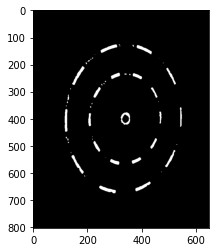

[327 401]


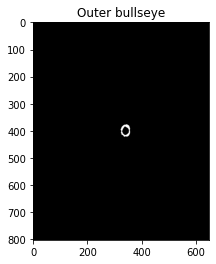

In [11]:
# show green bitmask
plt.imshow(Gmask, cmap='gray')
plt.show()

outerBullsEye = np.dstack((Gmask, Gmask, Gmask))

# find nearest whitepixel to avg point
target = (int(xAvg), int(yAvg))
nonzero = cv2.findNonZero(Gmask)
distances = np.sqrt((nonzero[:, :, 0] - target[0])
                    ** 2 + (nonzero[:, :, 1] - target[1])**2)
nearestIdx = np.argmin(distances)

nearestWhite = nonzero[nearestIdx][0]

print(nearestWhite)

# flood fill at nearestWhite
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(outerBullsEye, mask, (nearestWhite[0], nearestWhite[1]), 255)


# plt.title("Outer bullseye")
# plt.imshow(outerBullsEye, cmap='gray')
# plt.show()
# black out all non red
outerBullsEye = outerBullsEye.astype(float)
for i in range(outerBullsEye.shape[0]):
    for j in range(outerBullsEye.shape[1]):
        if np.array_equal(outerBullsEye[i][j], [255, 0, 0]):
            outerBullsEye[i][j] = (255, 255, 255)
        else:
            outerBullsEye[i][j] = (0, 0, 0)


outerBullsEye = outerBullsEye.astype(np.uint8)[:, :, 0]

plt.title("Outer bullseye")
plt.imshow(outerBullsEye, cmap='gray')
plt.savefig(outputLoc + 'outerBullseye.png')

plt.imshow(outerBullsEye, cmap='gray')
plt.show()


# Find triple ring

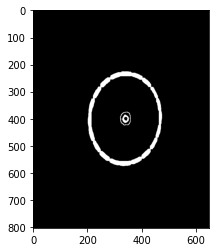

[257 262]


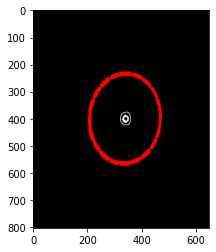

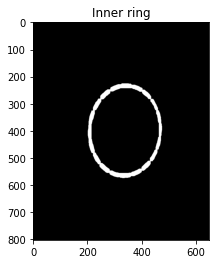

In [12]:
innerRing = outerBullsEye + innerBullseye + \
    doublePt + singlePoint + zeroPt[:, :, 0]
innerRing = 255 - innerRing
plt.imshow(innerRing, cmap='gray')
plt.show()
# find closest white to 0, 0
target = (0, 0)
innerRing = np.dstack((innerRing, innerRing, innerRing))
nonzero = cv2.findNonZero(innerRing[:, :, 0])
distances = np.sqrt((nonzero[:, :, 0] - target[0])
                    ** 2 + (nonzero[:, :, 1] - target[1])**2)
nearestIdx = np.argmin(distances)

nearestWhite = nonzero[nearestIdx][0]

print(nearestWhite)

# flood fill
mask = np.zeros((h+2, w+2), np.uint8)
# 8 connectivity flood fill

cv2.floodFill(innerRing, mask,
              (nearestWhite[0], nearestWhite[1]), 255, flags=8)
plt.imshow(innerRing, cmap='gray')
plt.show()
# black out all non red
innerRing = innerRing.astype(float)
for i in range(innerRing.shape[0]):
    for j in range(innerRing.shape[1]):
        if np.array_equal(innerRing[i][j], [255, 0, 0]):
            innerRing[i][j] = (255, 255, 255)
        else:
            innerRing[i][j] = (0, 0, 0)

innerRing = innerRing.astype(np.uint8)

plt.title("Inner ring")
plt.imshow(innerRing, cmap='gray')
plt.savefig(outputLoc + 'innerRing.png')

plt.imshow(innerRing, cmap='gray')
plt.show()


# Run the program on all test cases
We find the dart location and accordingly calculate the score accordingly

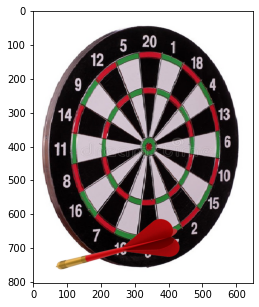

Score:  0


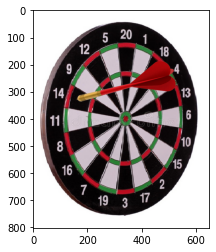

Score:  14


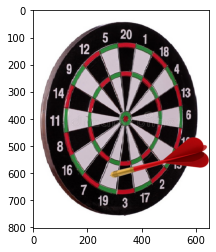

Score:  19


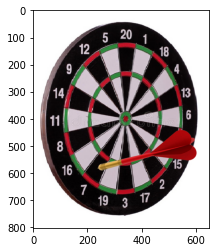

Score:  7


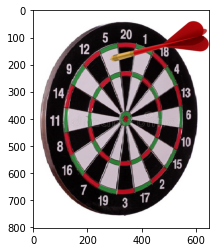

Score:  5


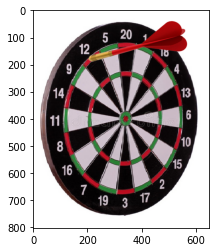

Outer Ring!
Score:  24


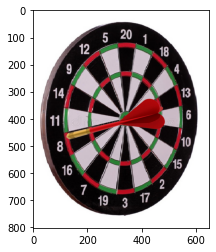

Outer Ring!
Score:  16


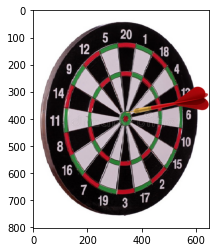

Outer bullseye!
Score:  25


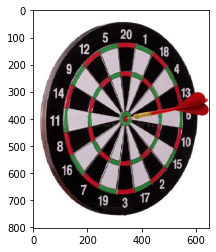

Inner Bullseye!
Score:  50


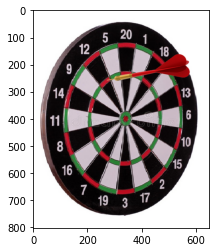

Inner Ring!
Score:  36


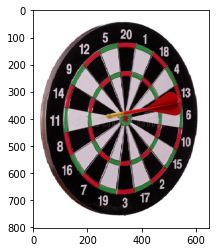

Score:  11


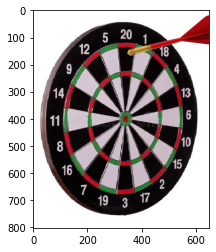

Score:  0


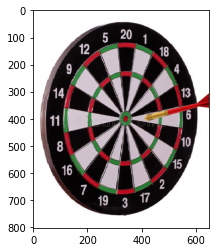

Score:  0


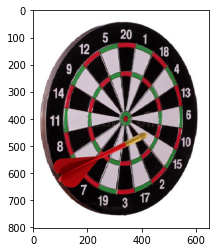

Score:  0


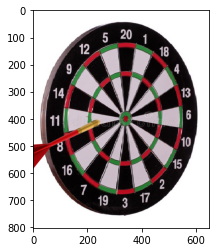

Score:  0


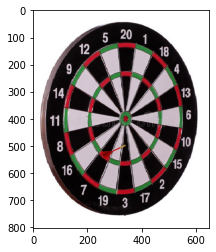

Inner Ring!
Score:  21


<Figure size 432x288 with 0 Axes>

In [13]:
tcs = ["Out", 14, 19, 7, 5, 24, 16, 25, 50, 36, 11, "F1", "F2", "F3", "F4", "F5"]
plt.figure(figsize=(5, 5))
for tc in tcs:
    #print("Target: ", tc)
    IMG_PATH1 = f"../data/inputs/dartSide{tc}.png"
    IMG_PATH = "../data/inputs/dartSide.jpg"


    image = cv2.imread(IMG_PATH)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Finding difference between dart board without dart and dart board with dart

    saliency = cv2.saliency.StaticSaliencyFineGrained_create()
    (success, saliencyMap) = saliency.computeSaliency(image)
    saliencyMap = (saliencyMap * 255).astype("uint8")

    image1 = cv2.imread(IMG_PATH1)
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    saliency = cv2.saliency.StaticSaliencyFineGrained_create()
    (success, saliencyMap1) = saliency.computeSaliency(image1)
    saliencyMap1 = (saliencyMap1 * 255).astype("uint8")

    finalimg = cv2.subtract(saliencyMap, saliencyMap1)
    threshMap = cv2.threshold(finalimg, 20, 255,
                            cv2.THRESH_BINARY)[1]

    plt.imshow(image1)
    plt.show()

    # plt.imshow(saliencyMap, cmap='gray')
    # plt.show()
    # plt.imshow(saliencyMap1, cmap='gray')
    # plt.show()
    # plt.imshow(finalimg, cmap='gray')
    # plt.show()
    # plt.imshow(threshMap, cmap='gray')
    # plt.show()
    
    # dilation on the dart with round structure on threshMap


    
    structure = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    # print(structure)

    dilated = cv2.dilate(threshMap, structure, iterations=5)

    # show
    # plt.imshow(dilated + doublePt, cmap='gray')
    # plt.show()

    # find two farthest white points
    nonzero = cv2.findNonZero(dilated)
    nonzero2d = np.squeeze(nonzero)
    convex = cv2.convexHull(nonzero2d)
    convex = np.squeeze(convex)
    # print(convex)

    # print
    #plt.imshow(dilated, cmap='gray')
    #plt.plot(convex[:, 0], convex[:, 1], 'r', linewidth=2)
    plt.savefig(outputLoc + f"dart{tc}.png")

    #plt.imshow(dilated, cmap='gray')
    #plt.plot(convex[:, 0], convex[:, 1], 'r', linewidth=2)
    #plt.show()

    # find white points at maximum distance
    maxDist = 0
    for i in range(convex.shape[0]):
        for j in range(i+1, convex.shape[0]):
            dist = np.sqrt((convex[i][0] - convex[j][0])**2 +
                        (convex[i][1] - convex[j][1])**2)
            if dist > maxDist:
                maxDist = dist
                maxDistIdx = (i, j)

    # print(maxDist)
    lined = np.dstack((dilated, dilated, dilated))
    cv2.line(lined, (convex[maxDistIdx[0]][0], convex[maxDistIdx[0]][1]), (convex[maxDistIdx[1]][0], convex[maxDistIdx[1]][1]), 255, 2)
    #plt.imshow(lined, cmap='gray')
    plt.savefig(outputLoc + f"dart{tc}lined.png")

    #plt.imshow(lined, cmap='gray')
    #plt.show()
    # left most point will always be our target point given position of dart board
    # find left most point
    pt1 = convex[maxDistIdx[0]]
    pt2 = convex[maxDistIdx[1]]

    if pt1[0] < pt2[0]:
        target = pt1
    else:
        target = pt2
        

    # Dartboard segmentation by line
    dartPoints = [6, 10, 15, 2, 17, 3, 19, 7, 16, 8, 11, 14, 9, 12, 5, 20, 1, 18, 4, 13]
    # Setting Thresholds (values subject to change)
    tl = 195
    tu = 255

    minlen = 120

    # Read image
    img = cv2.imread(inputLoc +'dartSide.jpg', cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blurred = cv2.blur(gray, (3, 3))
    
    # Apply Hough transform on the blurred image.
    linedge = cv2.Canny(img, tl, tu, L2gradient = True)
    lines = cv2.HoughLines(linedge, 1, np.pi/180, 100)
    linesamples = np.zeros((len(lines), 2))

    for i in range(len(lines)):
        linesamples[i][0] = 0
        linesamples[i][1] = lines[i][0][1] 
        
    kmeans = KMeans(n_clusters=10, random_state=0).fit(linesamples) 
    alreadyDone = set()
    allWhite = np.ones(img.shape, dtype=np.uint8)*255
    for i in range(0,len(lines)):
        label = kmeans.labels_[i]
        if label in alreadyDone:
            continue

        alreadyDone.add(label)
        pdist = lines[i][0][0]
        angle = lines[i][0][1]
        a = np.cos(angle)
        b = np.sin(angle)
        x0 = a * pdist
        y0 = b * pdist
        pt_start = (int(x0 + 10000*(-b)), int(y0 + 10000*(a)))
        pt_end = (int(x0 - 10000*(-b)), int(y0 - 10000*(a)))
        cv2.line(allWhite, pt_start, pt_end, (0,255,0), 1)

    #print(lines)

    # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # plt.show()

    # cv2.imshow("Edges", img)
    # cv2.waitKey(0)
    idx = 0
    # print(allWhite.shape)
    r = 100
    # Assign values to all sectors
    for theta in range(3, 360):
        # print(theta)
        radT = np.deg2rad(theta)
        xPt = int(r * np.cos(radT)) + allWhite.shape[1]//2
        yPt = int(r * np.sin(radT)) + allWhite.shape[0]//2
        point = [xPt, yPt]
        # print(point)

        # Calculating normal distance from point to every line

        line_order = []

        for i in range(len(lines)):
            pdist = lines[i][0][0]
            angle = lines[i][0][1]
            a = np.cos(angle)
            b = np.sin(angle)
            set_dist = abs(a*point[0] + b*point[1] - pdist)
            line_order.append([set_dist, pdist, angle])

        line_order = np.array(line_order)
        line_order = line_order[line_order[:,2].argsort()]

        #print(line_order)

        # finding two closest lines to point
        line1_p = line_order[0][1]
        line1_angle = line_order[0][2]

        line2_p = line_order[1][1]
        line2_angle = line_order[1][2]
        if allWhite[yPt][xPt][0] != 255:
            continue
        
        # print(idx)
        cv2.floodFill(allWhite, None, (xPt, yPt), (0, 0, dartPoints[idx] * 10))
        idx += 1


    if scoringRegion[target[1] - 10: target[1] + 10, target[0] - 10: target[0] + 10].sum() > 0:
        score = allWhite[target[1]][target[0]][2] // 10
    else:
        score = 0

    cv2.floodFill(allWhite, None, target, (0, 0, 255))
    # plt.imshow(cv2.cvtColor(allWhite, cv2.COLOR_BGR2RGB))

    # plt.show()
    if innerBullseye[target[1] - 10:target[1] + 10, target[0] - 10:target[0] + 10].sum() > 0:
        print("Inner Bullseye!")
        score = 50
    elif outerBullsEye[target[1] - 10:target[1] + 10, target[0] - 10:target[0] + 10].sum() > 0:
        print("Outer bullseye!")
        score = 25
    elif innerRing[target[1] - 10:target[1] + 10, target[0] - 10:target[0] + 10].sum() > 0:
        print("Inner Ring!")
        score *= 3
    elif doublePt[target[1] - 10:target[1] + 10, target[0] - 10:target[0] + 10].sum() > 0:
        print("Outer Ring!")
        score *= 2
    print("Score: ", score)